# Convolutional Neural Networks & Computer Vision

Computer vision offers a way to take real world images, and computationally analyze to predict and find patterns within visual data. For instance, the camera of a Self-Driving car.

* https://en.wikipedia.org/wiki/Convolutional_neural_network

Why can't this be done using normal Feed-Forward Neural Networks? Simple, the first step in analyzing an image with Feed Forward Neural Nets, you need to flatten the image to a single vector. For instance, a 28 x 28 pixel image flattens to a vector of length, 784. This is an extremely small image, and the inputs is of length 784. This is problematic with larger images because for the deep neural network to analyze, because there will be an extremely high number of weights to populate, and makes identifying patterns an extremly complex task.

The purpose of this notebook is to dig into Convolutional Neural Network architectures through analyzing a commonly used dataset, Food-101. The Food-101 dataset is commonly associated with CNN models because it offers a large dataset that can be used to analyze and predict images to determine the type of food the image represents.

* https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/
* https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

For this specific notebook, I am going to look at a condensed dataset consisting of only Pizza and Steak for a simple Binary Classification problem.

### Binary Classification (Breaking it Down Step-by-Step)
1. Become one with the data
2. Preprocess the data (scaled/normalized)
3. Created model (started with a simple baseline)
4. Fit the Model
5. Evaluate the Model
6. Adjust and improve the Model (Beat the baseline)
7. Repeat until optimal/satisfied

## Imports

In [1]:
import datetime
import logging
import os
import pathlib
import random
import sys

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from py_learning_toolbox import ml_toolbox
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Environment

Setting up the environment and analyzing the various information associated with this notebook.

In [2]:
print(f'Notebook last run (end-to-end): {datetime.datetime.now()}')

Notebook last run (end-to-end): 2023-09-19 13:59:50.815176


In [3]:
tf.__version__

'2.13.0'

In [4]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [5]:
# Setting up logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

## Global Constants

In [6]:
RANDOM_SEED = 42
IMAGE_SIZE = 224

## Downloading, Analyzing, & Creating Dataset

The dataset used is the Food 101 dataset commonly used to to explore Computer Vision. For simplicity of getting started with Computer Vision, I am only going to be looking at two image classes to work quickly with a smaller dataset before applying learnings to the larger dataset.

* https://www.kaggle.com/datasets/dansbecker/food-101 (original kaggle page of dataset)
* https://github.com/mrdbourke/tensorflow-deep-learning/ (getting the modified dataset)

### Downloading and Aanlyzing Data

In [7]:
# Image dataset location
data_directory = pathlib.Path('./data/food-101/pizza_steak')
test_directory = data_directory / 'test'
train_directory = data_directory / 'train'

In [8]:
# Lets look at the number of files in the test and train sets
ml_toolbox.analysis.image.summarize_directory(data_directory)

INFO:py_learning_toolbox.ml_toolbox.analysis.image:Directory: data/food-101/pizza_steak/test/steak Total Images: 250
INFO:py_learning_toolbox.ml_toolbox.analysis.image:Directory: data/food-101/pizza_steak/test/pizza Total Images: 250
INFO:py_learning_toolbox.ml_toolbox.analysis.image:Directory: data/food-101/pizza_steak/train/steak Total Images: 750
INFO:py_learning_toolbox.ml_toolbox.analysis.image:Directory: data/food-101/pizza_steak/train/pizza Total Images: 750


In [9]:
# Getting Class names programatically
class_names = ml_toolbox.analysis.image.get_classnames_from_directory(train_directory)
class_names

array(['pizza', 'steak'], dtype='<U5')

INFO:py_learning_toolbox.ml_toolbox.analysis.image:Pizza - Image Shape: (512, 512, 3)


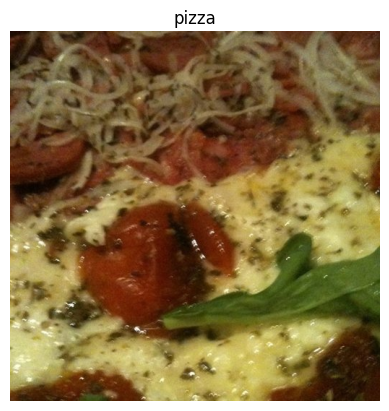

In [10]:
# View a random img from training dataset
pizza_img = ml_toolbox.analysis.image.plot_random_image_from_directory(train_directory, class_names[0])

INFO:py_learning_toolbox.ml_toolbox.analysis.image:Steak - Image Shape: (512, 382, 3)


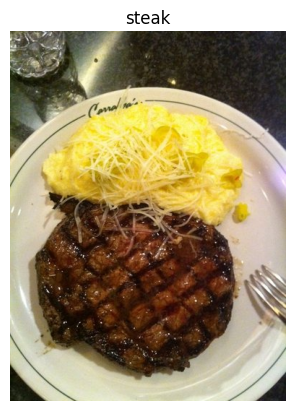

In [11]:
steak_img = ml_toolbox.analysis.image.plot_random_image_from_directory(train_directory, class_names[1])

### Creating Dataset

The next step is to turn out data into **batches**. A batch is a small subset of data. Rather than look at all ~10,000 images at one time, a model might only look at 32 at a time. It does this for a couple of reasons:

1. 10,000 images (or more) might not fit into the memory of the processor.
2. Trying to learn the patterns in 10,000 images in one hit could result in a poorly learned model.

**NOTE** A batch size of 32 is a commonly used batch size for neural networks, and has been tested and found that it is a good batch size for many scenarios.

For the purpose of exploring the various offerings of TensorFlow, I am going to use the `ImageDataGenerator` class for the datasets.

#### Augmented Data
Data augmentation is the process of altering our training data, leading it to have more diversity and in turn allowing ormodels to learn more generalizable (hopefully) patterns. Alterming might mean adjusting the rotation of an image, flipping it, cropping it, etc.

**NOTE** Data augmentation is usually only performed on the training data.

In [12]:
# Constants
SCALE = 1. / 255
BATCH_SIZE = 32

In [13]:
# Data Generators (Including Normalization)
train_data_gen = ImageDataGenerator(rescale=SCALE)
train_data_gen_augmented = ImageDataGenerator(rescale=SCALE,
                                              rotation_range=0.2,
                                              shear_range=0.2,
                                              zoom_range=0.2,
                                              width_shift_range=0.2,
                                              height_shift_range=0.3,
                                              horizontal_flip=True)

val_data_gen = ImageDataGenerator(rescale=SCALE)

In [14]:
# Import data from directories and turn it into batches
train_data = train_data_gen.flow_from_directory(
    directory=str(train_directory),
    batch_size=BATCH_SIZE,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    class_mode='binary',
    seed=RANDOM_SEED)

train_data_augmented = train_data_gen_augmented.flow_from_directory(
    directory=str(train_directory),
    batch_size=32,
    target_size=(224, 224),
    class_mode='binary')

val_data = val_data_gen.flow_from_directory(
    directory=str(test_directory),
    batch_size=BATCH_SIZE,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    class_mode='binary',
    shuffle=False)

Found 1500 images belonging to 2 classes.
Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


### Visualizing Augmented Data

Now that I have a dataset that has been augmented, I want to see what the images will look like.

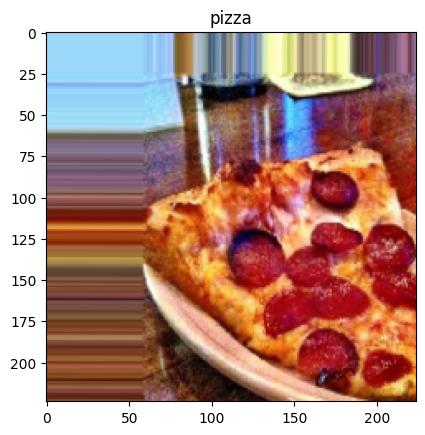

In [15]:
augmented_images, augmented_labels = train_data_augmented.next()
random_index = random.randint(0, len(augmented_images)-1)

ml_toolbox.analysis.image.plot_image_by_index(random_index, augmented_images, tf.cast(augmented_labels, dtype=tf.int32), class_names)

## Experiments
To get an understanding behind CNN architectures and layers, I am going to build out a handful of architectures in various experiments to get a better understanding and grasp on the various architectures that I can use with CNN models.

* Experiment-0: Simple CNN
* Experiment-1: Simple Feed Forward
* Experiment-2: Deeper Feed Forward
* Experiment-3: 2x Conv-Conv-Pool Architecture
* Experiment-4: 3x Conv-Pool Architecture
* Experiment-5: 3x Conv-Pool Architecture with Data Augmentation
* Experiment-6: 3x Conv-Pool Architecture with More Filters & Data Augmentation
* Experiment-7: 3x Conv-Pool Architecture with More Filters, Data Augmentation, and More Epochs


#### NOTE:
Fitting a machine learning model comes in 3 steps:

0. Create a baseline model to compare models against.
1. Beat the baseline by overfitting a larger model.
2. Reduce overfitting,

Ways to induce overfitting:

1. Increase the number of conv layers.
2. Increase the number of conv filters.
3. Add another dense layer to the output of our flattened layer.


Reduce overfitting:

1. Add data augmentation.
2. Add regularization (MaxPool2D).
3. Add more data

### Experiment Constants

Standard sonstants used across many/all experiments

In [16]:
OUTPUT_SIZE = 1

TRAIN_STEPS_PER_EPOCH = len(train_data)
TRAIN_AUG_STEPS_PER_EPOCH = len(train_data_augmented)
VAL_STEPS_PER_EPOCH = len(val_data)

EPOCHS = 5

### Experiment-0 (Baseline): Simple Convolutional Neural Network

To get a baseline model to compare my other experiments against, I will start with a simple model consisting of the following architecture.

* 3 Conv2D Layers - 10 filters
* Adam Optimizer
* 5 Epochs

In [17]:
# Constants
model_0_name = 'model_0_simple_cnn'

In [18]:
# Setting the random seed
tf.random.set_seed(RANDOM_SEED)

# Create Model
model_0 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=3,
                           strides=1,
                           padding='valid',
                           activation='relu',
                           input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
                           name='InputLayer'),
    tf.keras.layers.Conv2D(10, 3, activation='relu'),
    tf.keras.layers.Conv2D(10, 3, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(OUTPUT_SIZE, activation='sigmoid', name='OutputLayer'),
], name=model_0_name)

# Compile Model
model_0.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['accuracy'])

# Fit Model
# NOTE: train_data is a combination of X and y, so don't need to send both
# NOTE: We don't have a validation dataset, so going to use the test set
model_0_history = model_0.fit(train_data,
                              epochs=EPOCHS,
                              steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
                              validation_data=val_data,
                              validation_steps=VAL_STEPS_PER_EPOCH)

Epoch 1/5
47/47 [==============================] - 18s 379ms/step - loss: 1.4789 - accuracy: 0.5900 - val_loss: 0.5956 - val_accuracy: 0.6840
Epoch 2/5
47/47 [==============================] - 18s 372ms/step - loss: 0.5316 - accuracy: 0.7427 - val_loss: 0.4355 - val_accuracy: 0.8160
Epoch 3/5
47/47 [==============================] - 18s 375ms/step - loss: 0.4757 - accuracy: 0.7900 - val_loss: 0.4211 - val_accuracy: 0.8140
Epoch 4/5
47/47 [==============================] - 18s 376ms/step - loss: 0.3761 - accuracy: 0.8433 - val_loss: 0.4535 - val_accuracy: 0.7880
Epoch 5/5
47/47 [==============================] - 18s 374ms/step - loss: 0.2425 - accuracy: 0.9153 - val_loss: 0.4011 - val_accuracy: 0.8100


In [19]:
model_0.summary()

Model: "model_0_simple_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (Conv2D)         (None, 222, 222, 10)      280       
                                                                 
 conv2d (Conv2D)             (None, 220, 220, 10)      910       
                                                                 
 conv2d_1 (Conv2D)           (None, 218, 218, 10)      910       
                                                                 
 flatten (Flatten)           (None, 475240)            0         
                                                                 
 OutputLayer (Dense)         (None, 1)                 475241    
                                                                 
Total params: 477341 (1.82 MB)
Trainable params: 477341 (1.82 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


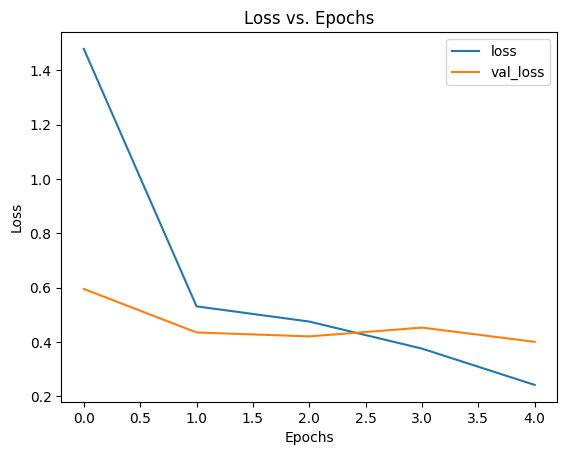

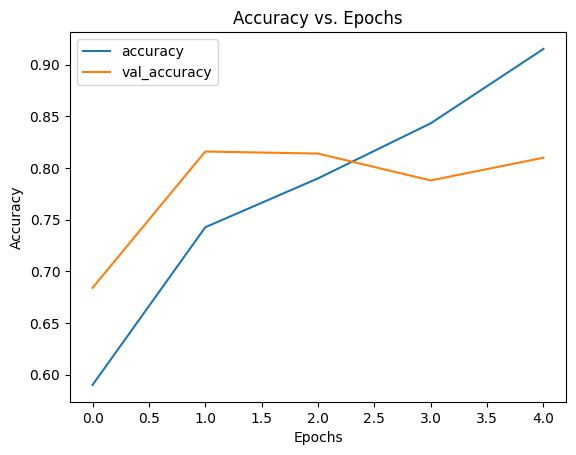

In [20]:
ml_toolbox.analysis.history.plot_history(model_0_history, 'loss')
ml_toolbox.analysis.history.plot_history(model_0_history, 'accuracy')

In [21]:
model_0_pred_probs = model_0.predict(val_data)
model_0_preds = tf.cast(tf.round(model_0_pred_probs), dtype=tf.int32)

model_0_results = ml_toolbox.analysis.classification.generate_prediction_metrics(val_data.classes, model_0_preds, name=model_0_name)
model_0_results

16/16 [==============================] - 2s 94ms/step


ClassificationPredictionMetrics(accuracy=0.81, precision=0.8118009623585831, recall=0.81, f1=0.8097252432512548, name='model_0_simple_cnn')

#### Findings

When a models's validation loss starts to increase, it's likely that the model is overfitting the training dataset This means it's learning the patterns in the training set too well and thus the model's ability to generalize unseen data will be diminished.

### Experiment-1: Feed Forward Neural Network (For Comparison)

To visualize the power behind a convolutional neural network, I am going to use a simple feed-forward neural network for comparison with the following architecture.

* 2 Dense Layers - 4 Neurons
* Adam Optimizer
* 5 Epochs

In [22]:
# Constants
model_1_name = 'model_1_feed_forward_nn'

In [23]:
# Setting random seed for comparison
tf.random.set_seed(RANDOM_SEED)

# Create Model
model_1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_SIZE, activation='sigmoid'),
], name=model_1_name)

# Compile Model
model_1.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['accuracy'])

# Fit Model
model_1_history = model_1.fit(train_data,
                              epochs=EPOCHS,
                              steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
                              validation_data=val_data,
                              validation_steps=VAL_STEPS_PER_EPOCH)

Epoch 1/5
47/47 [==============================] - 4s 81ms/step - loss: 0.7800 - accuracy: 0.4940 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/5
47/47 [==============================] - 4s 80ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/5
47/47 [==============================] - 4s 83ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/5
47/47 [==============================] - 4s 80ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/5
47/47 [==============================] - 4s 79ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000


In [24]:
# Looking at some details of model_2
# There are ~602,000 trainable parameters here (20X more parameters than model 1).
model_1.summary()

Model: "model_1_feed_forward_nn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 4)                 602116    
                                                                 
 dense_1 (Dense)             (None, 4)                 20        
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 602141 (2.30 MB)
Trainable params: 602141 (2.30 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


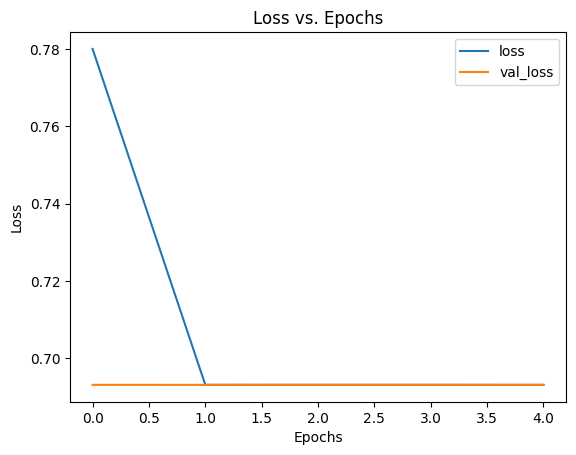

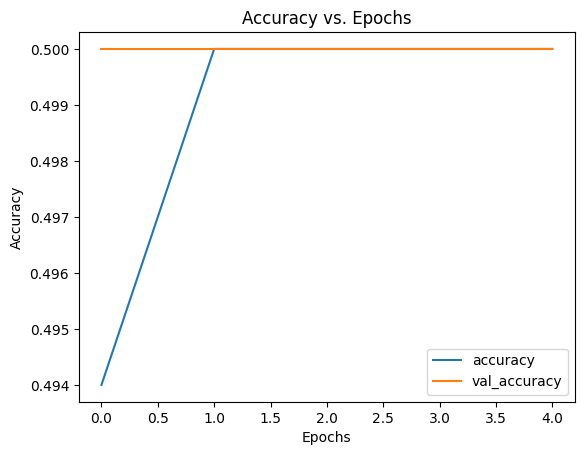

In [25]:
ml_toolbox.analysis.history.plot_history(model_1_history, 'loss')
ml_toolbox.analysis.history.plot_history(model_1_history, 'accuracy')

In [26]:
model_1_pred_probs = model_1.predict(val_data)
model_1_preds = tf.cast(tf.round(model_1_pred_probs), dtype=tf.int32)

model_1_results = ml_toolbox.analysis.classification.generate_prediction_metrics(val_data.classes, model_1_preds, name=model_1_name)
model_1_results

16/16 [==============================] - 1s 57ms/step


/Users/brandonkubick/Code/deep-learning-development/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ClassificationPredictionMetrics(accuracy=0.5, precision=0.25, recall=0.5, f1=0.3333333333333333, name='model_1_feed_forward_nn')

### Experiment-2: Larger Feed Forward Neural Network

Experiment-1 is a very simple feed forward network. I want to show that even larger feed forward models are still less powerful than a CNN for image recognition. I am going to build out a more complex feed forward model with following architecture.

* 3 Dense Layers - 100 Neurons
* Adam Optimizer
* 5 Epochs

In [27]:
# Constants
model_2_name = 'model_2_large_feed_forward_nn'

In [28]:
# See if we can make a better feed forward model
# Setting random seed for comparison
tf.random.set_seed(RANDOM_SEED)

# Create Model
model_2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_SIZE, activation='sigmoid')
])

# Compile Model
model_2.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['accuracy'])

# Fit Model
model_2_history = model_2.fit(train_data,
                              epochs=EPOCHS,
                              steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
                              validation_data=val_data,
                              validation_steps=VAL_STEPS_PER_EPOCH)

Epoch 1/5
47/47 [==============================] - 4s 83ms/step - loss: 1.7170 - accuracy: 0.6347 - val_loss: 1.5161 - val_accuracy: 0.6020
Epoch 2/5
47/47 [==============================] - 4s 84ms/step - loss: 0.9000 - accuracy: 0.6907 - val_loss: 0.5651 - val_accuracy: 0.7740
Epoch 3/5
47/47 [==============================] - 4s 84ms/step - loss: 0.6814 - accuracy: 0.7013 - val_loss: 0.4247 - val_accuracy: 0.8080
Epoch 4/5
47/47 [==============================] - 4s 83ms/step - loss: 0.5600 - accuracy: 0.7640 - val_loss: 0.7617 - val_accuracy: 0.6300
Epoch 5/5
47/47 [==============================] - 4s 82ms/step - loss: 0.5430 - accuracy: 0.7620 - val_loss: 0.4519 - val_accuracy: 0.7700


In [29]:
# Looking at model 3 structure
# ~15 million trainable parameters (500X number of trainable parameters compared to the CNN)
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 150528)            0         
                                                                 
 dense_3 (Dense)             (None, 100)               15052900  
                                                                 
 dense_4 (Dense)             (None, 100)               10100     
                                                                 
 dense_5 (Dense)             (None, 100)               10100     
                                                                 
 dense_6 (Dense)             (None, 1)                 101       
                                                                 
Total params: 15073201 (57.50 MB)
Trainable params: 15073201 (57.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


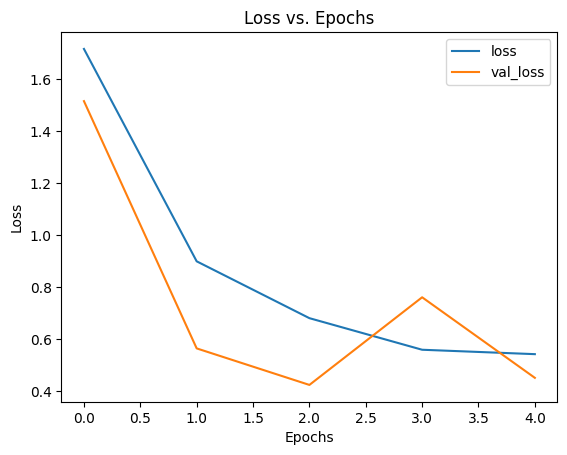

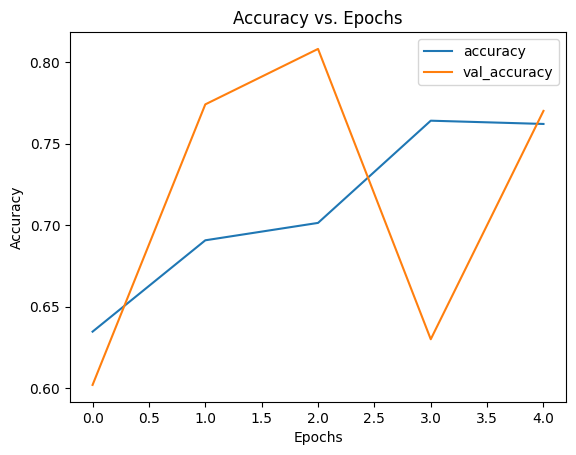

In [30]:
ml_toolbox.analysis.history.plot_history(model_2_history, 'loss')
ml_toolbox.analysis.history.plot_history(model_2_history, 'accuracy')

In [31]:
model_2_pred_probs = model_2.predict(val_data)
model_2_preds = tf.cast(tf.round(model_2_pred_probs), dtype=tf.int32)

model_2_results = ml_toolbox.analysis.classification.generate_prediction_metrics(val_data.classes, model_2_preds, name=model_2_name)
model_2_results

16/16 [==============================] - 1s 58ms/step


ClassificationPredictionMetrics(accuracy=0.77, precision=0.8178504831327343, recall=0.77, f1=0.7610051913828864, name='model_2_large_feed_forward_nn')

### Experiment-3: Multi Conv-Conv-Pool CNN

The next step is to analyze a more complex CNN. This experiment consists of a model with the following architecture.

* 2 Conv2D-Conv2D-MaxPool2D Layers - 10 filters
* Adam Optimizer
* 5 Epochs

In [32]:
# Constants
model_3_name = 'model_3_conv_conv_pool'

In [33]:
# Setting the random seed
tf.random.set_seed(RANDOM_SEED)

# Build the CNN Model
model_3 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=3,
                           activation='relu',
                           input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    tf.keras.layers.Conv2D(10, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2,
                              padding='valid'),
    tf.keras.layers.Conv2D(10, 3, activation='relu'),
    tf.keras.layers.Conv2D(10, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(OUTPUT_SIZE, activation='sigmoid'),
], name=model_3_name)

# Compile CNN Model
model_3.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics='accuracy')

# Fit the CNN Model
model_3_history = model_3.fit(train_data,
                              epochs=EPOCHS,
                              validation_data=val_data,
                              steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
                              validation_steps=VAL_STEPS_PER_EPOCH)

Epoch 1/5
47/47 [==============================] - 15s 313ms/step - loss: 0.6382 - accuracy: 0.6440 - val_loss: 0.5300 - val_accuracy: 0.6960
Epoch 2/5
47/47 [==============================] - 14s 307ms/step - loss: 0.4744 - accuracy: 0.7647 - val_loss: 0.3630 - val_accuracy: 0.8480
Epoch 3/5
47/47 [==============================] - 14s 307ms/step - loss: 0.3987 - accuracy: 0.8240 - val_loss: 0.3604 - val_accuracy: 0.8420
Epoch 4/5
47/47 [==============================] - 15s 313ms/step - loss: 0.3909 - accuracy: 0.8300 - val_loss: 0.4434 - val_accuracy: 0.7880
Epoch 5/5
47/47 [==============================] - 15s 313ms/step - loss: 0.3636 - accuracy: 0.8407 - val_loss: 0.3275 - val_accuracy: 0.8660


In [34]:
model_3.summary()

Model: "model_3_conv_conv_pool"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 conv2d_3 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 10)      0         
 D)                                                              
                                                                 
 conv2d_4 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_5 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 53, 10)        0         
 g2D)                                       

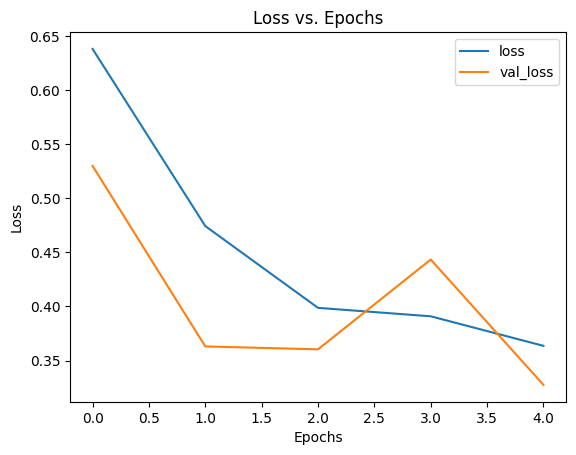

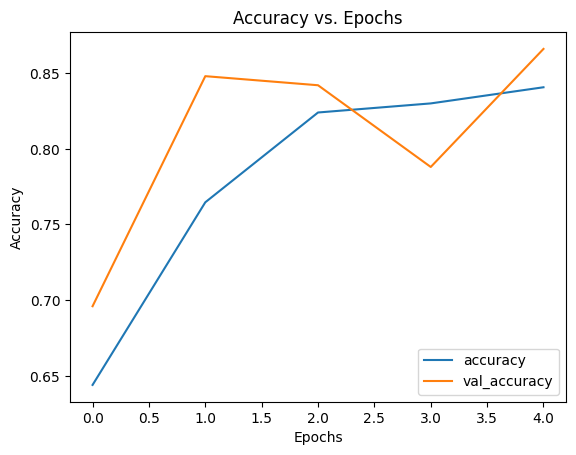

In [35]:
ml_toolbox.analysis.history.plot_history(model_3_history, 'loss')
ml_toolbox.analysis.history.plot_history(model_3_history, 'accuracy')

In [36]:
model_3_pred_probs = model_3.predict(val_data)
model_3_preds = tf.cast(tf.round(model_3_pred_probs), dtype=tf.int32)

model_3_results = ml_toolbox.analysis.classification.generate_prediction_metrics(val_data.classes, model_3_preds, name=model_3_name)
model_3_results

16/16 [==============================] - 1s 79ms/step


ClassificationPredictionMetrics(accuracy=0.866, precision=0.8709920692842894, recall=0.866, f1=0.8655477024711129, name='model_3_conv_conv_pool')

### Experiment-4: Multi Conv-Pool CNN

An alternate architecture commonly used consists of multiple Conv layers before pooling. This experiment consists of a model with the following architecture.

* 3 Conv2D-MaxPool2D Layers - 10 filters
* Adam Optimizer
* 5 Epochs

In [37]:
# Constants
model_4_name = 'model_4_conv_pool'

In [38]:
# Setting the random seed
tf.random.set_seed(RANDOM_SEED)

# Create Model
model_4 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=3,
                           strides=1,
                           padding='valid',
                           activation='relu',
                           input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
                           name='InputLayer'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(10, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(10, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(OUTPUT_SIZE, activation='sigmoid', name='OutputLayer')
])

# Compile Model
model_4.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['accuracy'])

# Fit Model
# NOTE: train_data is a combination of X and y, so don't need to send both
# NOTE: We don't have a validation dataset, so going to use the test set
model_4_history = model_4.fit(train_data,
                              epochs=EPOCHS,
                              steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
                              validation_data=val_data,
                              validation_steps=VAL_STEPS_PER_EPOCH)

Epoch 1/5
47/47 [==============================] - 7s 142ms/step - loss: 0.6264 - accuracy: 0.6693 - val_loss: 0.4823 - val_accuracy: 0.7540
Epoch 2/5
47/47 [==============================] - 6s 137ms/step - loss: 0.4593 - accuracy: 0.7860 - val_loss: 0.3638 - val_accuracy: 0.8420
Epoch 3/5
47/47 [==============================] - 6s 137ms/step - loss: 0.4041 - accuracy: 0.8147 - val_loss: 0.3389 - val_accuracy: 0.8640
Epoch 4/5
47/47 [==============================] - 6s 137ms/step - loss: 0.4153 - accuracy: 0.8180 - val_loss: 0.3500 - val_accuracy: 0.8740
Epoch 5/5
47/47 [==============================] - 6s 137ms/step - loss: 0.3724 - accuracy: 0.8460 - val_loss: 0.3336 - val_accuracy: 0.8740


In [39]:
model_4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (Conv2D)         (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 10)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 54, 54, 10)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 52, 52, 10)        910       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 26, 26, 10)       

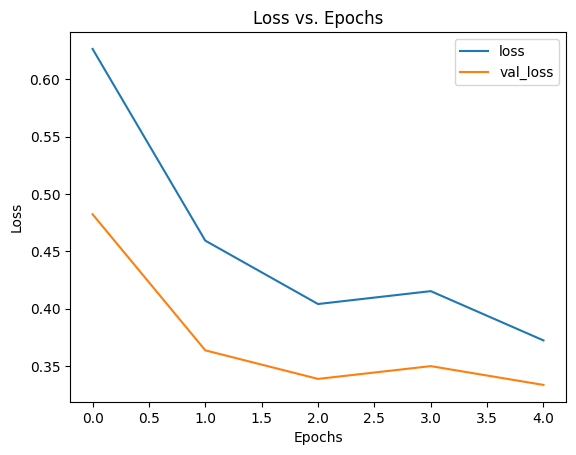

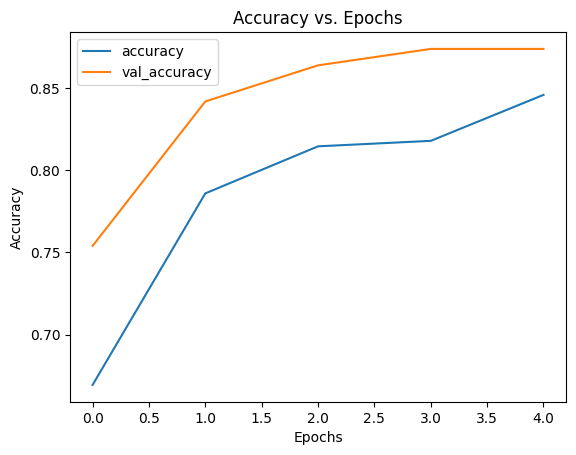

In [40]:
ml_toolbox.analysis.history.plot_history(model_4_history, 'loss')
ml_toolbox.analysis.history.plot_history(model_4_history, 'accuracy')

In [41]:
model_4_pred_probs = model_4.predict(val_data)
model_4_preds = tf.cast(tf.round(model_4_pred_probs), dtype=tf.int32)

model_4_results = ml_toolbox.analysis.classification.generate_prediction_metrics(val_data.classes, model_4_preds, name=model_4_name)
model_4_results

16/16 [==============================] - 1s 63ms/step


ClassificationPredictionMetrics(accuracy=0.874, precision=0.8747254685070297, recall=0.874, f1=0.8739389864694512, name='model_4_conv_pool')

#### Findings

After implementing pooling into the CNN, the training data set and the validation (testing in our case) data set followed a similar trajectory. This is what we want to see in our models which limits overfitting.

NOTE: Reducing overfitting is also know as regularization.

### Experiment-5: Multi Conv-Pool CNN w/ Data Augmentation

Data augmentation is a simple way to make smaller models more performant. This experiment consists of the same architecture as in Experiment-4 (architecture below).

* 3 Conv2D-MaxPool2D Layers - 10 filters
* Adam Optimizer
* 5 Epochs

In [42]:
# Constants
model_5_name = 'model_5_conv_pool_aug'

In [43]:
# Setting the random seed
tf.random.set_seed(RANDOM_SEED)

# Create Model
model_5 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=3,
                           strides=1,
                           padding='valid',
                           activation='relu',
                           input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
                           name='InputLayer'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(10, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(10, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(OUTPUT_SIZE, activation='sigmoid', name='OutputLayer'),
], name=model_5_name)

# Compile Model
model_5.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['accuracy'])

# Fit Model
# NOTE: train_data is a combination of X and y, so don't need to send both
# NOTE: We don't have a validation dataset, so going to use the test set
model_5_history = model_5.fit(train_data_augmented,
                              epochs=EPOCHS,
                              steps_per_epoch=TRAIN_AUG_STEPS_PER_EPOCH,
                              validation_data=val_data,
                              validation_steps=VAL_STEPS_PER_EPOCH)

Epoch 1/5
47/47 [==============================] - 11s 229ms/step - loss: 0.6494 - accuracy: 0.6127 - val_loss: 0.4883 - val_accuracy: 0.8020
Epoch 2/5
47/47 [==============================] - 11s 232ms/step - loss: 0.5478 - accuracy: 0.7240 - val_loss: 0.4603 - val_accuracy: 0.7840
Epoch 3/5
47/47 [==============================] - 11s 233ms/step - loss: 0.5043 - accuracy: 0.7580 - val_loss: 0.4160 - val_accuracy: 0.8040
Epoch 4/5
47/47 [==============================] - 11s 229ms/step - loss: 0.4960 - accuracy: 0.7660 - val_loss: 0.3471 - val_accuracy: 0.8520
Epoch 5/5
47/47 [==============================] - 11s 229ms/step - loss: 0.4692 - accuracy: 0.7767 - val_loss: 0.3423 - val_accuracy: 0.8580


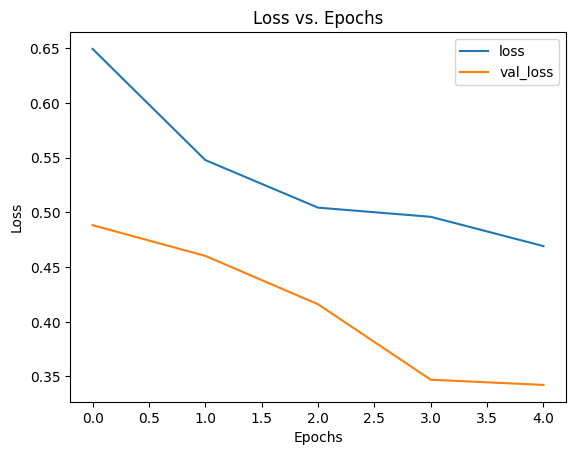

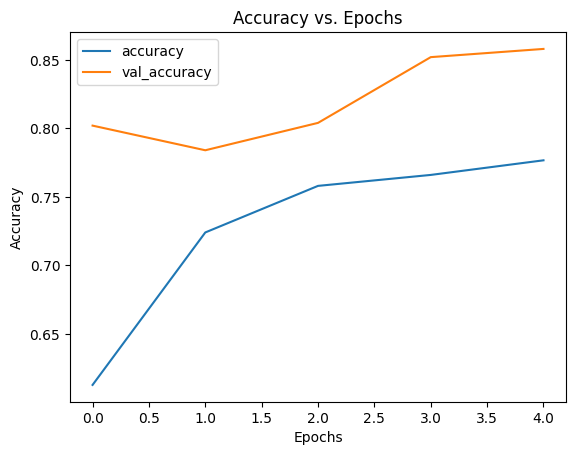

In [44]:
ml_toolbox.analysis.history.plot_history(model_5_history, 'loss')
ml_toolbox.analysis.history.plot_history(model_5_history, 'accuracy')

In [45]:
model_5_pred_probs = model_5.predict(val_data)
model_5_preds = tf.cast(tf.round(model_5_pred_probs), dtype=tf.int32)

model_5_results = ml_toolbox.analysis.classification.generate_prediction_metrics(val_data.classes, model_5_preds, name=model_5_name)
model_5_results

16/16 [==============================] - 1s 64ms/step


ClassificationPredictionMetrics(accuracy=0.858, precision=0.8596630820915916, recall=0.858, f1=0.8578356580206719, name='model_5_conv_pool_aug')

### Experiment 6: Multi Conv-Pool w/ Data Augmentation and More Filters

Since we've already beaten our baseline, there are a few things to try to improve the model:

1. Increate number of model layers.
2. Increate filters in each layer.
3. Train for longer..
4. Find ideal learning rate.
5. More data!
6. Use transfer learning.

This experiment consists of a similar architecture to Experiment-5, but with more filters for each Conv layer in addition to data augmentation.

* 3 Conv2D-MaxPool2D Layers - 20 filters
* Adam Optimizer
* 5 Epochs

In [46]:
# Constants
model_6_name = 'model_6_conv_pool_aug_filters'

CONV_FILTERS_6 = 20

In [47]:
# Setting the random seed
tf.random.set_seed(RANDOM_SEED)

# Create Model
model_6 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=CONV_FILTERS_6,
                           kernel_size=3,
                           strides=1,
                           padding='valid',
                           activation='relu',
                           input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
                           name='InputLayer'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(CONV_FILTERS_6, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(CONV_FILTERS_6, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(OUTPUT_SIZE, activation='sigmoid', name='OutputLayer'),
], name=model_6_name)

# Compile Model
model_6.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['accuracy'])

# Fit Model
# NOTE: train_data is a combination of X and y, so don't need to send both
# NOTE: We don't have a validation dataset, so going to use the test set
model_6_history = model_6.fit(train_data_augmented,
                              epochs=EPOCHS,
                              steps_per_epoch=TRAIN_AUG_STEPS_PER_EPOCH,
                              validation_data=val_data,
                              validation_steps=VAL_STEPS_PER_EPOCH)

Epoch 1/5
47/47 [==============================] - 12s 248ms/step - loss: 0.6609 - accuracy: 0.5827 - val_loss: 0.5550 - val_accuracy: 0.6780
Epoch 2/5
47/47 [==============================] - 11s 240ms/step - loss: 0.5500 - accuracy: 0.7187 - val_loss: 0.4088 - val_accuracy: 0.8180
Epoch 3/5
47/47 [==============================] - 11s 235ms/step - loss: 0.4781 - accuracy: 0.7793 - val_loss: 0.3438 - val_accuracy: 0.8620
Epoch 4/5
47/47 [==============================] - 11s 236ms/step - loss: 0.4687 - accuracy: 0.7920 - val_loss: 0.3720 - val_accuracy: 0.8360
Epoch 5/5
47/47 [==============================] - 11s 236ms/step - loss: 0.4483 - accuracy: 0.8167 - val_loss: 0.3438 - val_accuracy: 0.8620


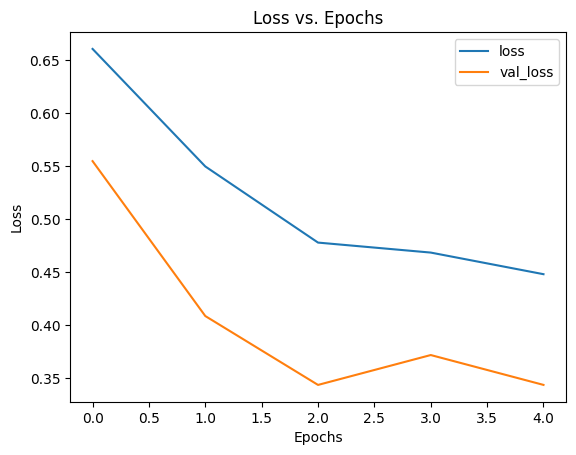

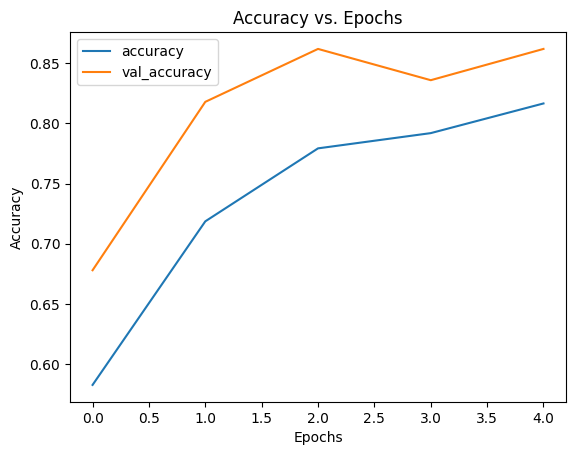

In [48]:
ml_toolbox.analysis.history.plot_history(model_6_history, 'loss')
ml_toolbox.analysis.history.plot_history(model_6_history, 'accuracy')

In [49]:
model_6_pred_probs = model_6.predict(val_data)
model_6_preds = tf.cast(tf.round(model_6_pred_probs), dtype=tf.int32)

model_6_results = ml_toolbox.analysis.classification.generate_prediction_metrics(val_data.classes, model_6_preds, name=model_6_name)
model_6_results

16/16 [==============================] - 1s 63ms/step


ClassificationPredictionMetrics(accuracy=0.862, precision=0.8741215378255477, recall=0.862, f1=0.8608730718822463, name='model_6_conv_pool_aug_filters')

### Experiment 7: Multi Conv-Pool w/ Data Augmentation and More Filters, Double Num Epochs

Experiment-6 performed exceptionally well. I am going to build off of Experiment-6 by utilizing the same architecture, but with additional epochs.

* 3 Conv2D-MaxPool2D Layers - 20 filters
* Adam Optimizer
* 10 Epochs

In [69]:
# Constants
model_7_name = 'model_7_conv_pool_aug_filters_epochs'

CONV_FILTERS_7 = 20
EPOCHS_7 = 10

In [51]:
# Setting the random seed
tf.random.set_seed(RANDOM_SEED)

# Create Model
model_7 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=CONV_FILTERS_7,
                           kernel_size=3,
                           strides=1,
                           padding='valid',
                           activation='relu',
                           input_shape=(224, 224, 3),
                           name='InputLayer'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(CONV_FILTERS_7, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(CONV_FILTERS_7, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(OUTPUT_SIZE, activation='sigmoid', name='OutputLayer'),
], name=model_7_name)

# Compile Model
model_7.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['accuracy'])

# Fit Model
# NOTE: train_data is a combination of X and y, so don't need to send both
# NOTE: We don't have a validation dataset, so going to use the test set
model_7_history = model_7.fit(train_data_augmented,
                              epochs=EPOCHS_7,
                              steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
                              validation_data=val_data,
                              validation_steps=VAL_STEPS_PER_EPOCH)

Epoch 1/10
47/47 [==============================] - 11s 238ms/step - loss: 0.6631 - accuracy: 0.5647 - val_loss: 0.6701 - val_accuracy: 0.5900
Epoch 2/10
47/47 [==============================] - 12s 252ms/step - loss: 0.5876 - accuracy: 0.6667 - val_loss: 0.3729 - val_accuracy: 0.8380
Epoch 3/10
47/47 [==============================] - 12s 256ms/step - loss: 0.4804 - accuracy: 0.7667 - val_loss: 0.4584 - val_accuracy: 0.7580
Epoch 4/10
47/47 [==============================] - 12s 253ms/step - loss: 0.4726 - accuracy: 0.7853 - val_loss: 0.3189 - val_accuracy: 0.8640
Epoch 5/10
47/47 [==============================] - 12s 248ms/step - loss: 0.4621 - accuracy: 0.7760 - val_loss: 0.4158 - val_accuracy: 0.8320
Epoch 6/10
47/47 [==============================] - 12s 258ms/step - loss: 0.4481 - accuracy: 0.8073 - val_loss: 0.3130 - val_accuracy: 0.8620
Epoch 7/10
47/47 [==============================] - 12s 256ms/step - loss: 0.4361 - accuracy: 0.7973 - val_loss: 0.3021 - val_accuracy: 0.8720

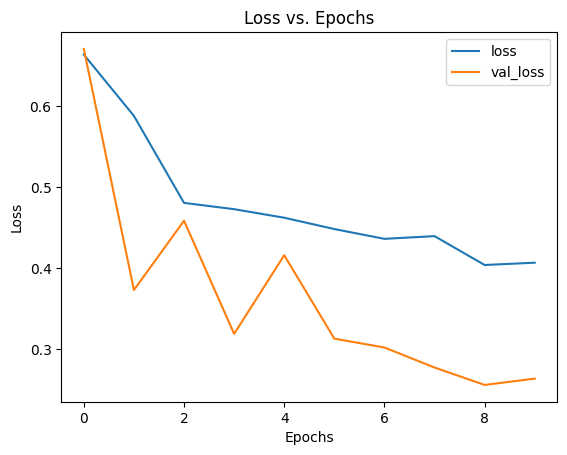

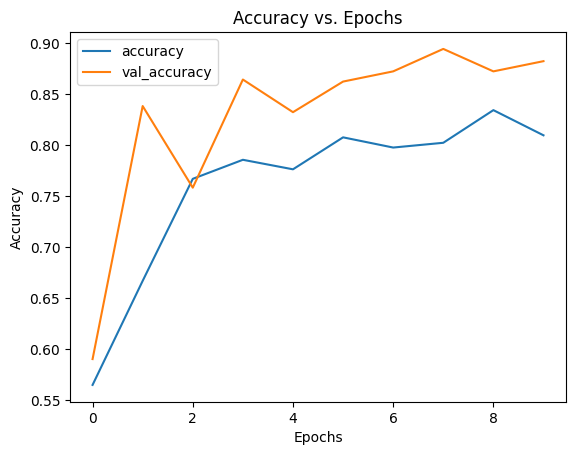

In [52]:
ml_toolbox.analysis.history.plot_history(model_7_history, 'loss')
ml_toolbox.analysis.history.plot_history(model_7_history, 'accuracy')

In [70]:
model_7_pred_probs = model_7.predict(val_data)
model_7_preds = tf.cast(tf.round(model_7_pred_probs), dtype=tf.int32)

model_7_results = ml_toolbox.analysis.classification.generate_prediction_metrics(val_data.classes, model_7_preds, name=model_7_name)
model_7_results

16/16 [==============================] - 1s 78ms/step


ClassificationPredictionMetrics(accuracy=0.882, precision=0.882495714445922, recall=0.882, f1=0.8819617556088173, name='model_7_conv_pool_aug_filters_epochs')

## Analysis

After running the handful of experiments, I want to compare them all to identify the optimally performing model to run tests on custom images. Additionally, I will export that model to be used outside of this notebook.

In [71]:
all_results = [
    model_0_results,
    model_1_results,
    model_2_results,
    model_3_results,
    model_4_results,
    model_5_results,
    model_6_results,
    model_7_results,
]

results_df = ml_toolbox.analysis.classification.generate_prediction_metrics_dataframe(all_results)
results_df

,accuracy,precision,recall,f1
model_0_simple_cnn,0.810,0.811801,0.810,0.809725
model_1_feed_forward_nn,0.500,0.250000,0.500,0.333333
model_2_large_feed_forward_nn,0.770,0.817850,0.770,0.761005
model_3_conv_conv_pool,0.866,0.870992,0.866,0.865548
model_4_conv_pool,0.874,0.874725,0.874,0.873939
model_5_conv_pool_aug,0.858,0.859663,0.858,0.857836
model_6_conv_pool_aug_filters,0.862,0.874122,0.862,0.860873
model_7_conv_pool_aug_filters_epochs,0.882,0.882496,0.882,0.881962


<Axes: >

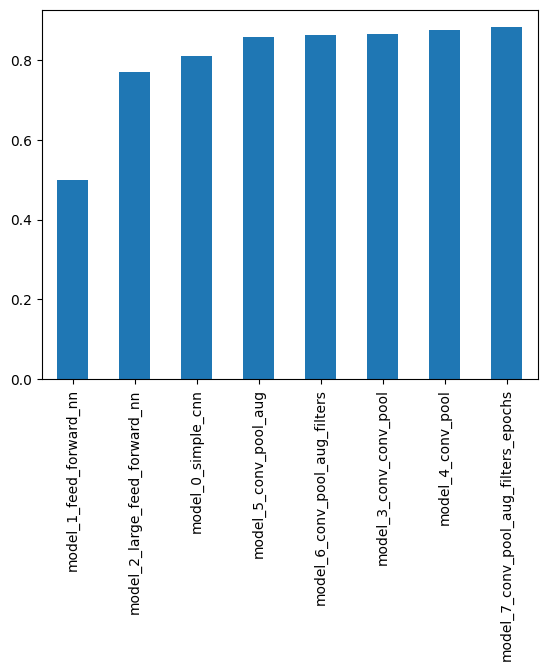

In [72]:
results_df['accuracy'].sort_values().plot(kind='bar')

##### Findings

After analyzing the table and plot of the accuracy performance of all the models shows that Experiment-7 (model-7) outperformed all other models. Additionally, it is worth pointing out that even the simple CNN outperformed both the feed-forward architectures built out.

### Testing Custom Images

I want to see the best model (Experiment-7) make predictions on custom images.

In [56]:
# Test Image location
test_image_directory = pathlib.Path('./data/food-101/model_testing')
steak_filename = test_image_directory / 'steak' / 'steak-and-eggs.jpeg'
steak_filename

PosixPath('data/food-101/model_testing/steak/steak-and-eggs.jpeg')

In [57]:
# Load and prep image
steak = ml_toolbox.preprocessing.image.load_and_resize_image(str(steak_filename))

1/1 [==============================] - 0s 17ms/step


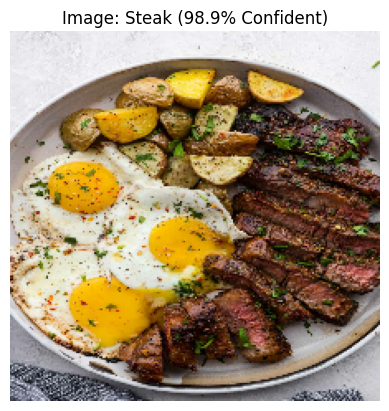

In [63]:
ml_toolbox.analysis.image.predict_and_plot_image(model_7, steak, class_names)

## Saving Model

After comparing all the experiments, it appears that Experiment-7 had the best performance. In the event I want to use this model outside of this notebook, I am going to export it and verify that the model performs roughly equivalently when it is reimported.

In [73]:
filepath = f'./models/food_101_2_classes/{model_7_name}'

In [74]:
model_7.save(filepath)

INFO:tensorflow:Assets written to: ./models/food_101_2_classes/model_7_conv_pool_aug_filters_epochs/assets
INFO:tensorflow:Assets written to: ./models/food_101_2_classes/model_7_conv_pool_aug_filters_epochs/assets


In [75]:
loaded_model_7 = tf.keras.models.load_model(filepath)

In [76]:
loaded_model_7.evaluate(val_data)

16/16 [==============================] - 1s 81ms/step - loss: 0.2637 - accuracy: 0.8820


[0.2637427747249603, 0.8820000290870667]

In [77]:
model_7.evaluate(val_data)

16/16 [==============================] - 1s 76ms/step - loss: 0.2637 - accuracy: 0.8820


[0.2637427747249603, 0.8820000290870667]